In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
sys.path.append('../scripts')
from scripts.data_handler import DataOrganize


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
import glob

files = glob.glob('../data/StockTwits.*_messages.csv')

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file and load the first 1000 rows into a dataframe
for file in files:
    df = pd.read_csv(file, nrows=100)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [3]:
data_organize = DataOrganize(data)
data_organize.clean_data()

100%|██████████| 1000/1000 [00:18<00:00, 54.33it/s]
d:\University\researches\fazli\code\crypto_sentiment\Notebooks\..\scripts\data_analysis.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  raw_data['language'], raw_data['entities'] = zip(*[extract_features(str(x)) for x in tqdm(raw_data['body'])])


<class 'str'>


100%|██████████| 658/658 [00:00<00:00, 20616.07it/s]


In [4]:
coins_list = [
    {"name": "Cardano", "symbol": "ADA"},
    {"name": "Avalanche", "symbol": "AVAX"},
    {"name": "Binance Coin", "symbol": "BNB"},
    {"name": "Bitcoin", "symbol": "BTC"},
    {"name": "Dogecoin", "symbol": "DOGE"},
    {"name": "Polkadot", "symbol": "DOT"},
    {"name": "Ethereum", "symbol": "ETH"},
    {"name": "Polygon", "symbol": "MATIC"},
    {"name": "Solana", "symbol": "SOL"},
    {"name": "TRON", "symbol": "TRX"},
    {"name": "Ripple", "symbol": "XRP"}
]

In [5]:

coins_name = [coin['name'] for coin in coins_list]
coins_symbol = [coin['symbol'] for coin in coins_list]
data_organize.filter_by_coin(coins_name,coins_symbol)
data_organize.analyze_sentiment()

  0%|          | 0/658 [00:00<?, ?it/s]

100%|██████████| 658/658 [00:09<00:00, 66.23it/s]


In [10]:
from datetime import datetime
from importlib import reload
from scripts.portfolio_manager import PortfolioManager
portfolio = PortfolioManager(coins_list,data_organize.data)
date_string = "17 November 2023"

current_date = pd.to_datetime(date_string, format="%d %B %Y")
weights = portfolio.getWeights(current_date)
print(weights)

{'ADA': 0.45400205263304694, 'AVAX': 0.28783670015532453, 'BTC': 0.2581612472116285}


In [11]:

weights = {key + '-USD': value*100 for key, value in weights.items()}
average_index = {}
for coin in coins_list:
  coin_symbol = coin['symbol']
  average_index[coin_symbol] = 1/len(coins_list)

average_index = {key + '-USD': value*100 for key, value in average_index.items()}

members = []
members+=average_index.keys()


def PortfolioCalc(weightings, data, name):
  data[name] = sum([  int(weightings[x])*data[x]/100 for x in list(weightings.keys())   ])
  return data

basedata = yf.Ticker(members[0]).history(period="max").reset_index()[["Date","Open"]]
basedata["Date"] = pd.to_datetime(basedata["Date"])
basedata["Date"] = basedata["Date"].dt.date
basedata = basedata.rename(columns = {"Open":members[0]})
if (len(members)>1):
  for x in range(1,len(members)):
    newdata = yf.Ticker(members[x]).history(period="max").reset_index()[["Date","Open"]]
    newdata["Date"] = pd.to_datetime(newdata["Date"])
    newdata["Date"] = newdata["Date"].dt.date
    newdata = newdata.rename(columns = {"Open":members[x]})
    basedata = pd.merge(basedata, newdata, on="Date")

basedata = basedata[  basedata["Date"] > pd.to_datetime("2021-05-01")]
print(basedata)

            Date   ADA-USD   AVAX-USD     BNB-USD       BTC-USD  DOGE-USD  \
222   2021-05-02  1.351402  31.794001  619.972107  57825.863281  0.391087   
223   2021-05-03  1.326938  31.324923  621.902710  56620.273438  0.373631   
224   2021-05-04  1.362939  35.876583  676.315918  57214.179688  0.440274   
225   2021-05-05  1.270986  30.292955  609.331055  53252.164062  0.537355   
226   2021-05-06  1.478110  35.253933  651.049500  57441.308594  0.652842   
...          ...       ...        ...         ...           ...       ...   
1198  2024-01-03  0.605669  40.645931  312.151611  44961.601562  0.091205   
1199  2024-01-04  0.557277  36.795128  316.624451  42855.816406  0.082049   
1200  2024-01-05  0.570543  38.737286  323.620239  44192.980469  0.084121   
1201  2024-01-06  0.541309  36.434498  317.495178  44178.953125  0.082773   
1202  2024-01-07  0.523169  34.629585  307.794067  43998.464844  0.080668   

        DOT-USD      ETH-USD  MATIC-USD     SOL-USD   TRX-USD   XRP-USD  
2

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [12]:
for x in members:
  basedata[x] = basedata[x]/(basedata[x].iloc[0])

basedata = PortfolioCalc(weights, basedata, "crypto1")
basedata = PortfolioCalc(average_index, basedata, "crypto2")

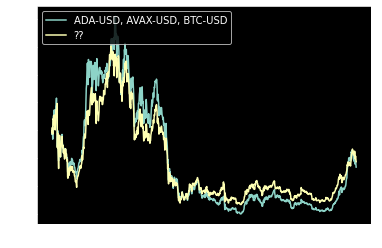

In [13]:
plt.style.use("dark_background")

plt.plot(basedata["Date"], basedata["crypto1"], label = ', '.join(weights.keys()))
plt.plot(basedata["Date"], basedata["crypto2"], label = "??")

plt.legend(loc="upper left")
plt.show()